In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import NamedTuple
import math
from enum import Enum, auto
import re
from matplotlib.ticker import PercentFormatter

In [2]:
class Actor(Enum):
    GAITNET = "gaitnet"
    CONTACTNET = "contactnet"

In [3]:
file_name_regex = re.compile(r'([a-zA-Z]+)_eval_d(\d+(?:\.\d+)?)_v(\d+(?:\.\d+)?)(?:_commit(\w+))?\.csv')
"""match groups:
 - 1: network (gaitnet or contactnet)
 - 2: terrain difficulty (float)
 - 3: command velocity (float)
 - 4: commit (str)
"""

class DataPoint(NamedTuple):
    network: Actor
    commit: str 
    terrain_difficulty: float
    command_velocity: float
    distances: np.ndarray
    success: np.ndarray

    @staticmethod
    def from_csv(file_path: Path) -> "DataPoint":
        df = pd.read_csv(file_path)

        match = file_name_regex.match(file_path.name)
        if match is None:
            raise ValueError(f"Filename {file_path.name} does not match expected pattern")

        if len(match.groups()) == 3:
            network_str, terrain_difficulty, command_velocity = match.groups()
            commit = "unknown"
        else:
            network_str, terrain_difficulty, command_velocity, commit = match.groups()

        network = Actor(network_str)
        terrain_difficulty = float(terrain_difficulty)
        command_velocity = float(command_velocity)

        distances = df['distance'].to_numpy()
        success = df['truncated'].to_numpy().astype(bool)
        
        return DataPoint(
            network=network,
            commit=commit,
            terrain_difficulty=terrain_difficulty,
            command_velocity=command_velocity,
            distances=distances,
            success=success
        )

In [4]:
data_folder = Path.cwd()  / "data" / "contactnet_00000000_000000-00000000-baseline-method"
data_files = list(data_folder.glob("*.csv"))
all_data_points = [DataPoint.from_csv(fp) for fp in data_files]
all_data_points

[DataPoint(network=<Actor.CONTACTNET: 'contactnet'>, commit=None, terrain_difficulty=0.2, command_velocity=0.1, distances=array([1.8497806 , 0.49237198, 1.0435039 , 0.5616661 , 0.85560095,
        0.4576023 , 1.0768985 , 1.0454892 , 0.9500444 , 1.5853752 ,
        0.51919204, 0.60359657, 1.7026452 , 1.9139795 , 0.54485047,
        1.5884827 , 1.183885  , 0.5690786 , 1.7437335 , 1.084283  ,
        0.7049632 , 0.7966336 , 1.7580785 , 1.0026511 , 0.66148806,
        0.4699032 , 1.6246827 , 1.2721796 , 1.1273763 , 1.0974749 ,
        1.7777265 , 0.5715584 , 0.79975986, 1.4514942 , 0.77074146,
        0.94379514, 1.8241946 , 0.68975425, 1.0987239 , 0.8509996 ,
        1.7483097 , 1.5535762 , 1.7415401 , 0.68640107, 0.82032275,
        1.1335799 , 1.2988347 , 1.9155924 , 0.816214  , 0.57555145,
        0.44836637, 0.651297  , 0.5205669 , 0.9872445 , 0.54277456,
        0.6975849 , 0.6550022 , 1.5989937 , 0.8139878 , 2.040615  ,
        0.5341237 , 0.75313234, 1.659452  , 0.35517523, 0.81325

In [5]:
# get a map from (network, commit) to list of DataPoints
data_map: dict[tuple[Actor, str], list[DataPoint]] = {}
for dp in all_data_points:
    key = (dp.network, dp.commit)
    if key not in data_map:
        data_map[key] = []
    data_map[key].append(dp)

In [6]:
def auc(data: list[DataPoint]) -> float:
    """Compute the area under the curve for the given data points."""
    auc = 0.0
    for datum in data:
        auc += float(np.mean(datum.success))
    return auc

def mean_success(data: list[DataPoint]) -> float:
    return auc(data)/len(data)


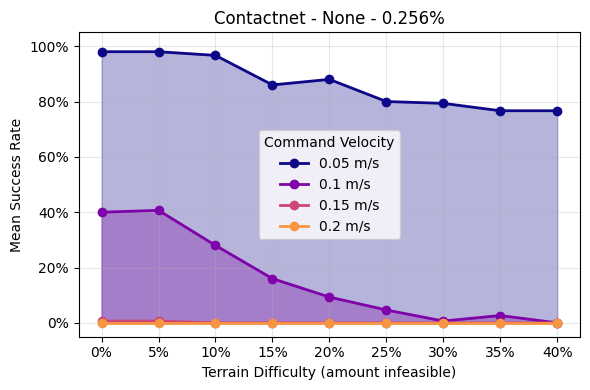

In [ ]:
# plot 2d line plots of terrain difficulty (x) and mean success rate (y)
# one plot for each network, with a line for each command velocity

# Use a colormap for velocity progression
cmap = plt.cm.plasma
colors = cmap(np.linspace(0, 1, 5))  # 4 velocities

# Ensure images directory exists
images_dir = Path.cwd() / "images"
images_dir.mkdir(exist_ok=True)

for (network, commit), network_data in data_map.items():
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Get unique terrain difficulties and command velocities
    unique_difficulties = sorted(set(dp.terrain_difficulty for dp in network_data))
    unique_velocities = sorted(set(dp.command_velocity for dp in network_data))
    
    # Plot a line for each command velocity with color progression
    for i, velocity in enumerate(unique_velocities):
        velocity_data = [dp for dp in network_data if dp.command_velocity == velocity]
        velocity_data = sorted(velocity_data, key=lambda dp: dp.terrain_difficulty)
        
        difficulties = [dp.terrain_difficulty for dp in velocity_data]
        success_rates = [np.mean(dp.success) for dp in velocity_data]
        
        ax.plot(difficulties, success_rates, marker='o', label=f'{velocity} m/s', 
                linewidth=2, markersize=6, color=colors[i])
        ax.fill_between(difficulties, success_rates, alpha=0.3, color=colors[i])
    
    ax.set_title(f'{network.value.capitalize()} - {commit} - {mean_success(network_data):.3f}%')
    ax.set_xlabel('Terrain Difficulty (amount infeasible)')
    ax.set_ylabel('Mean Success Rate')
    ax.set_ylim(-0.05, 1.05)
    
    # Format axes as percentages (assumes values in [0, 1])
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    # Set x-axis ticks to only show where data points exist
    ax.set_xticks(unique_difficulties)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(title='Command Velocity', loc='best')

    plt.tight_layout(w_pad=5.0)  # Increase horizontal padding between subplots
    plt.savefig(images_dir / f'{network.value.capitalize()} - {commit}.png', dpi=300, bbox_inches='tight', pad_inches=0.3)


# Aggregated Experiment Plots

Load and plot data aggregated by experiment name across all subdirectories in the data folder.

In [8]:
# Parse experiment names from directory names and load all data
experiment_name_regex = re.compile(r'^\w+?_\w+?_\w+?-\w+?-(.+)$')

# Get all subdirectories in the data folder
data_root = Path.cwd() / "data"
experiment_dirs = [d for d in data_root.iterdir() if d.is_dir()]

# Map from (network, experiment_name) to list of experiment runs
# Each experiment run is represented by all DataPoints from one folder
experiment_runs_map: dict[tuple[Actor, str], list[list[DataPoint]]] = {}

for exp_dir in experiment_dirs:
    match = experiment_name_regex.match(exp_dir.name)
    if match is None:
        print(f"Skipping directory {exp_dir.name} - doesn't match expected pattern")
        continue
    
    experiment_name = match.group(1)
    
    # Load all CSV files in this directory - they represent one experiment run
    csv_files = list(exp_dir.glob("*.csv"))
    experiment_run = [DataPoint.from_csv(csv_file) for csv_file in csv_files]
    
    if experiment_run:
        # All files in the same folder should have the same network type
        network = experiment_run[0].network
        key = (network, experiment_name)
        
        if key not in experiment_runs_map:
            experiment_runs_map[key] = []
        experiment_runs_map[key].append(experiment_run)

print(f"Found {len(experiment_runs_map)} unique (network, experiment) combinations:")
for key, runs in experiment_runs_map.items():
    network, exp_name = key
    total_data_points = sum(len(run) for run in runs)
    print(f"  {network.value} - {exp_name}: {len(runs)} experiment runs, {total_data_points} total data points")

Found 4 unique (network, experiment) combinations:
  contactnet - baseline-method: 1 experiment runs, 36 total data points
  gaitnet - survival-curr: 2 experiment runs, 70 total data points
  gaitnet - footstep-cost: 1 experiment runs, 36 total data points
  gaitnet - dist-curr: 1 experiment runs, 35 total data points


## Option 1: Individual Lines for Each Experiment Run

Shows all individual experiment runs on the same graph.

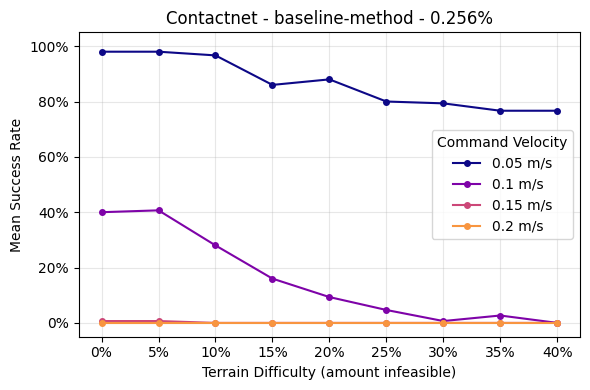

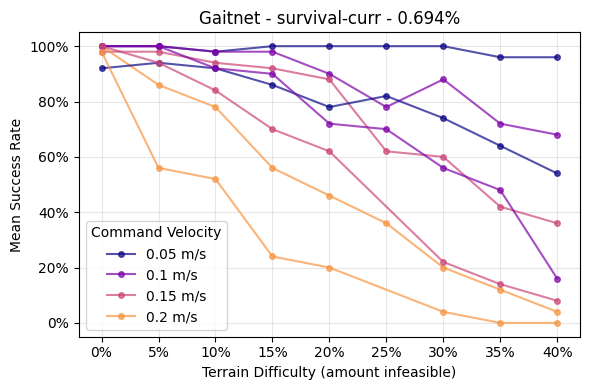

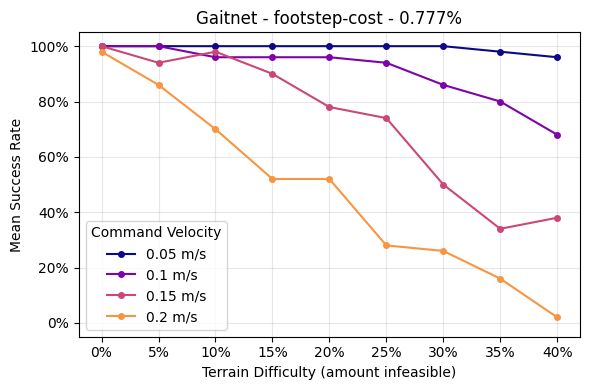

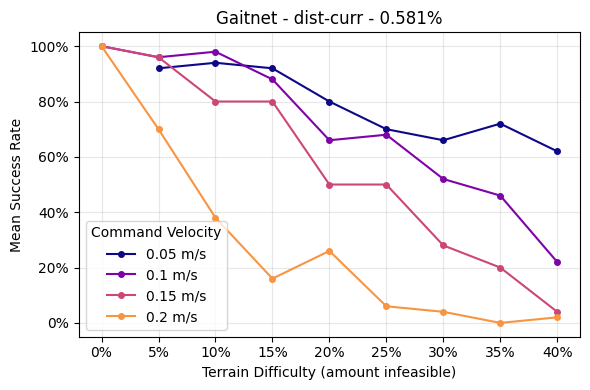

In [ ]:
# Plot aggregated data with individual lines for each experiment run
# Each experiment run (folder) gets its own set of lines

cmap = plt.cm.plasma
colors = cmap(np.linspace(0, 1, 5))  # 4 velocities

# Ensure images directory exists
images_dir = Path.cwd() / "images"
images_dir.mkdir(exist_ok=True)

for (network, experiment_name), experiment_runs in experiment_runs_map.items():
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Flatten all data points to find unique velocities
    all_data_points = [dp for run in experiment_runs for dp in run]
    unique_velocities = sorted(set(dp.command_velocity for dp in all_data_points))
    all_difficulties = set()
    
    # Plot lines for each experiment run
    for run_idx, experiment_run in enumerate(experiment_runs):
        # Plot a line for each velocity in this experiment run
        for i, velocity in enumerate(unique_velocities):
            velocity_data = [dp for dp in experiment_run if dp.command_velocity == velocity]
            velocity_data = sorted(velocity_data, key=lambda dp: dp.terrain_difficulty)
            
            if not velocity_data:
                continue
            
            difficulties = [dp.terrain_difficulty for dp in velocity_data]
            success_rates = [np.mean(dp.success) for dp in velocity_data]
            all_difficulties.update(difficulties)
            
            # Only add label for the first run to avoid cluttering legend
            label = f'{velocity} m/s' if run_idx == 0 else None
            alpha = 0.7 if len(experiment_runs) > 1 else 1.0
            
            ax.plot(difficulties, success_rates, marker='o', label=label,
                    linewidth=1.5, markersize=4, color=colors[i], alpha=alpha)
    
    ax.set_title(f'{network.value.capitalize()} - {experiment_name} - {mean_success(all_data_points):.3f}%')
    ax.set_xlabel('Terrain Difficulty (amount infeasible)')
    ax.set_ylabel('Mean Success Rate')
    ax.set_ylim(-0.05, 1.05)
    
    # Format axes as percentages
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    # Set x-axis ticks to only show where data points exist
    ax.set_xticks(sorted(all_difficulties))
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(title='Command Velocity', loc='best')
    
    plt.tight_layout()
    plt.savefig(images_dir / f'{network.value.capitalize()} - {experiment_name} - individual.png', dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()


## Option 2: Mean with Confidence Intervals

Shows the mean success rate across all experiment runs with 95% confidence intervals (standard error).

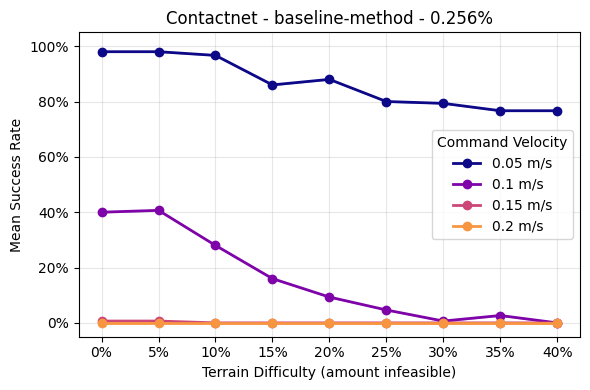

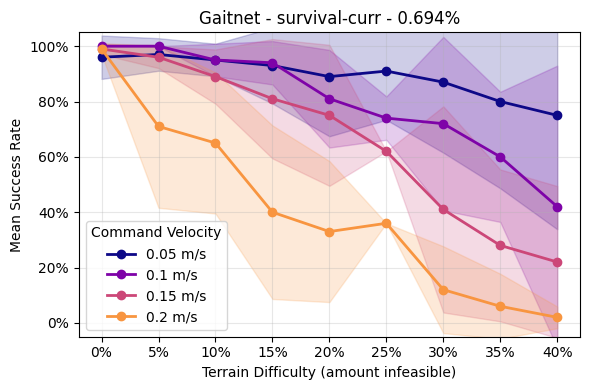

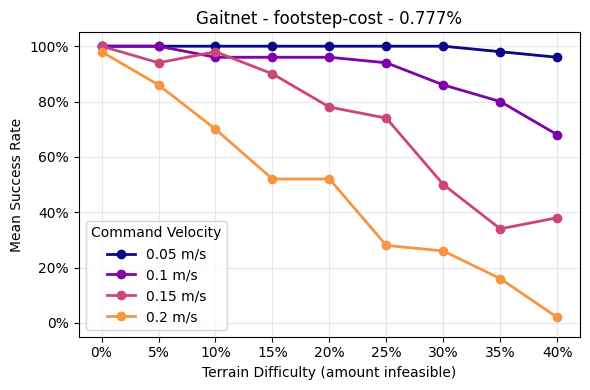

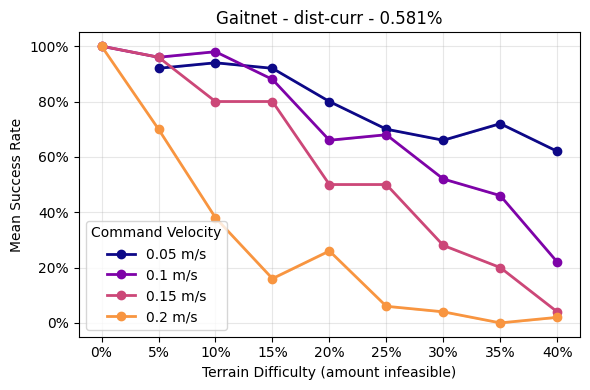

In [ ]:
# Plot aggregated data with mean and confidence intervals
# Average across all experiment runs for each (difficulty, velocity) combination

cmap = plt.cm.plasma
colors = cmap(np.linspace(0, 1, 5))  # 4 velocities

# Ensure images directory exists
images_dir = Path.cwd() / "images"
images_dir.mkdir(exist_ok=True)

for (network, experiment_name), experiment_runs in experiment_runs_map.items():
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Flatten all data points
    all_data_points = [dp for run in experiment_runs for dp in run]
    unique_velocities = sorted(set(dp.command_velocity for dp in all_data_points))
    unique_difficulties = sorted(set(dp.terrain_difficulty for dp in all_data_points))
    
    # Plot a line for each velocity with error bars
    for i, velocity in enumerate(unique_velocities):
        # Group by terrain difficulty and compute statistics across experiment runs
        difficulty_stats = {}
        
        for difficulty in unique_difficulties:
            # Get success rate from each experiment run at this (difficulty, velocity)
            run_success_rates = []
            for experiment_run in experiment_runs:
                matching_points = [dp for dp in experiment_run 
                                 if dp.command_velocity == velocity 
                                 and dp.terrain_difficulty == difficulty]
                if matching_points:
                    # Should only be one match per run, but take mean just in case
                    run_success_rates.append(np.mean([np.mean(dp.success) for dp in matching_points]))
            
            if run_success_rates:
                mean_rate = np.mean(run_success_rates)
                
                # Compute standard error for confidence interval
                if len(run_success_rates) > 1:
                    std_error = np.std(run_success_rates, ddof=1) / np.sqrt(len(run_success_rates))
                    # 95% confidence interval (approximately 1.96 * SE)
                    ci = 1.96 * std_error
                else:
                    ci = 0
                
                difficulty_stats[difficulty] = (mean_rate, ci)
        
        if difficulty_stats:
            difficulties = sorted(difficulty_stats.keys())
            means = [difficulty_stats[d][0] for d in difficulties]
            cis = [difficulty_stats[d][1] for d in difficulties]
            
            # Plot mean line with markers
            ax.plot(difficulties, means, marker='o', label=f'{velocity} m/s',
                    linewidth=2, markersize=6, color=colors[i])
            
            # Add confidence interval shading
            means_array = np.array(means)
            cis_array = np.array(cis)
            ax.fill_between(difficulties, means_array - cis_array, means_array + cis_array,
                           alpha=0.2, color=colors[i])
    
    ax.set_title(f'{network.value.capitalize()} - {experiment_name} - {mean_success(all_data_points):.3f}%')
    ax.set_xlabel('Terrain Difficulty (amount infeasible)')
    ax.set_ylabel('Mean Success Rate')
    ax.set_ylim(-0.05, 1.05)
    
    # Format axes as percentages
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    # Set x-axis ticks to only show where data points exist
    ax.set_xticks(unique_difficulties)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(title='Command Velocity', loc='best')
    
    plt.tight_layout()
    plt.savefig(images_dir / f'{network.value.capitalize()} - {experiment_name} - mean_ci.png', dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
